resources:
https://distill.pub/2019/visual-exploration-gaussian-processes/
https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.03-Gaussian-Process-Regression.html
https://domino.ai/blog/fitting-gaussian-process-models-python
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py

In [ ]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
import pickle
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, 
import numpy as np
import seaborn as sns
import matplotlib

# map

In [2]:
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)
X, Y = get_map_grid(polygon, map_boundary, 10)
grid = np.array((Y, X)).T

NameError: name 'points' is not defined

In [ ]:
map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    map = np.vstack((map, pred))
    

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


In [ ]:
map = map.T

In [ ]:
np.savetxt(f'intermediate/map_gp_{region}.txt', map)

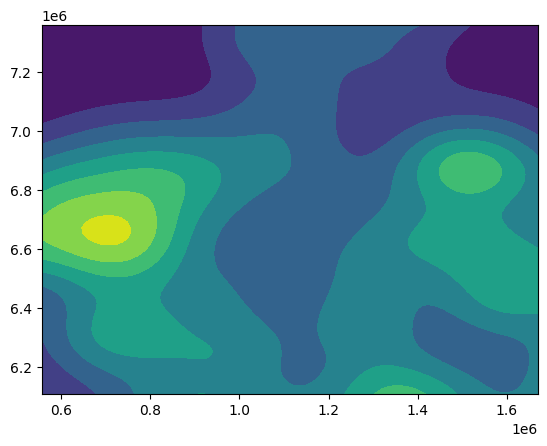

In [ ]:
# preview
p = plt.contourf(X, Y, map)
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

# 1D

In [2]:
points = get_points('../data/artificial_points_gp.csv')

points = points[points.lat == 0]

points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lon']].values
y = points['wait'].values

# assuming mean = 0 in the gp setup
average = np.mean(y)

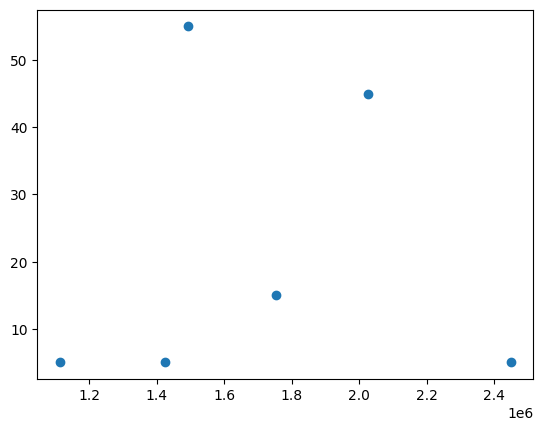

In [3]:
plt.scatter(X, y, label="Observations")

In [4]:
# larger rbf sigma (stdv) to allow deviation from 0 (mean) -> factor before rbf kernel via constant kernel -> sigma
# larger rbf length for more smoothness -> length scale of rbf kernel -> l

# error (noise) stdv added to diagonal of kernel matrix as parameter -> alpha

# parameters to optimize
sigma = 10.0
sigma_bounds = (1e-1,1e7) # unit are minutes

l = 1e6  # only lon dimensions; set starting value to 1000km
length_scale_bounds = (5e4, 1e7) # from the scatter plot above; in the metirc crs this implies influence between 10km and 10000km

alpha = 0.0 # as WhiteKernel is used to optimized noise

noise_level = 1.0
noise_level_bounds = (1e-1,1e1)  # unit are minutes

rbf = RBF(
    length_scale=l, length_scale_bounds=length_scale_bounds
)

kernel = ConstantKernel(
    constant_value=sigma, constant_value_bounds=sigma_bounds
) * rbf + WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=alpha**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=1000,
    random_state=42,
)

# try adujusting the mean to 0 vs. setting normalize_y to True (this is not preferred as it also standardizes which results in less intuitive kernel parameters)
# setting noise per datapoint with more noise on larger values

# WhiteKernel can be used instead of alpha to optimize noise (per datapoint) as well -> set alpha to 0
# set WhiteKernel bounds narrow to not overfit noise (everything is explained by noise)

In [5]:
gp.fit(X, y - average);

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:16<00:00, 61.00it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [6]:
gp.kernel_, np.exp(gp.kernel_.theta)
# note that length_scale and noise_level take the values at the bounds of the allowed range (indicator that this is not a local optimum)

(23.1**2 * RBF(length_scale=5e+04) + WhiteKernel(noise_level=10),
 array([5.35730192e+02, 5.00000000e+04, 1.00000000e+01]))

In [7]:
x_test = np.linspace(start=1000000, stop=2600000, num=300)
x_test = np.array([[xi] for xi in x_test])

In [8]:
y_pred, std_prediction = gp.predict(x_test, return_std=True)
y_pred = y_pred + average # add back the mean

Text(0, 0.5, '$f(x)$')

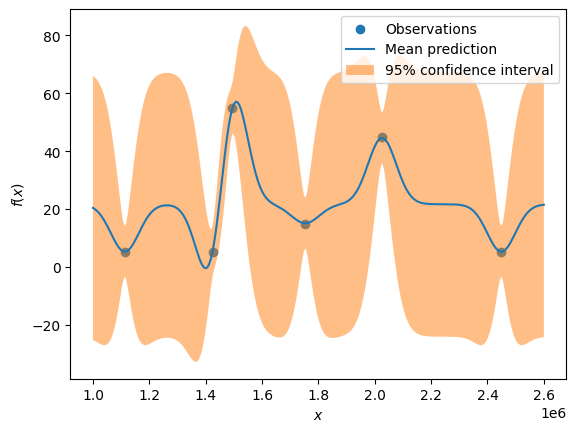

In [9]:
plt.scatter(X, y, label="Observations")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - 1.96 * std_prediction,
    y_pred + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

In [10]:
# TODO: constraining so that predictions cannot drop below 0 (wait time cannot be negative)
# TODO: prevent getting hyperparameters at interval bounds

## hyperparam search

In [11]:
from matplotlib.colors import LogNorm

length_scale = np.logspace(4, 7, num=50)
noise_level = np.logspace(-2, 2, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

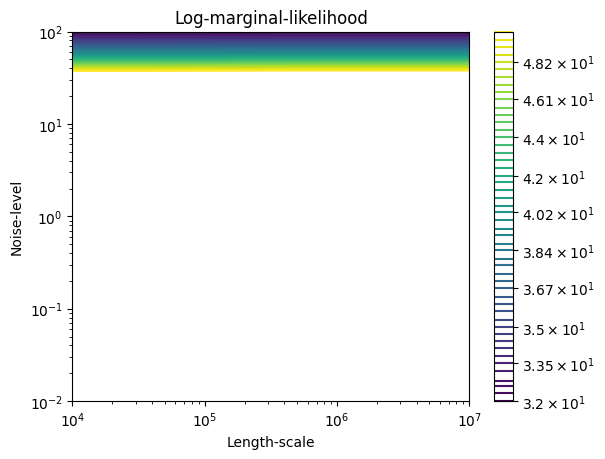

In [12]:
vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

In [13]:
# plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
# plt.plot(x, y, "ro")

In [14]:


# Root mean squared error ... for eval

In [15]:
stop

NameError: name 'stop' is not defined

# 2D using location

In [16]:
points = get_points('../data/points_train.csv')
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

average = np.mean(y)

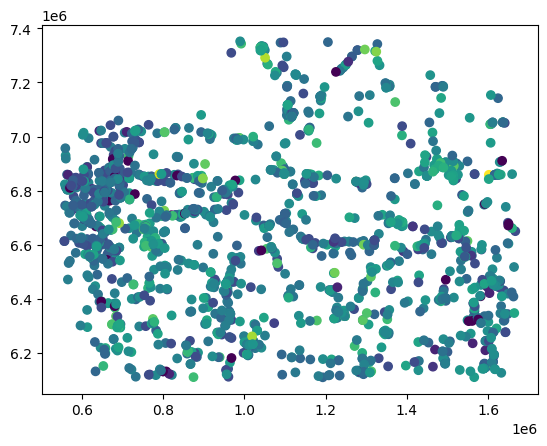

In [17]:
plt.scatter(X[:,1], X[:,0], c=y, norm='log', label="Observations")

In [18]:
# parameters to optimize
sigma = 10.0
sigma_bounds = (1e-1,1e7) # unit are minutes

l = [1e6, 1e6]  # lat and lon dimensions; set starting value to 1000km
length_scale_bounds = (5e4, 1e7) # from the scatter plot above; in the metirc crs this implies influence between 10km and 10000km

alpha = 0.0 # as WhiteKernel is used to optimized noise

noise_level = 1.0
noise_level_bounds = (1e-1,1e1)  # unit are minutes

rbf = RBF(
    length_scale=l, length_scale_bounds=length_scale_bounds
)  # using anisotripic kernel (different length scales for each dimension)

kernel = ConstantKernel(
    constant_value=sigma, constant_value_bounds=sigma_bounds
) * rbf + WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=alpha**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=1000,
    random_state=42,
)

In [19]:
gp.fit(X, y - average)
with open('models/gp_model.pkl', 'wb') as f:
    pickle.dump(gp, f)
gp = pickle.load(open('models/gp_model.pkl', 'rb'))

100%|██████████| 1000/1000 [14:50<00:00,  1.12it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower

In [20]:
gp.kernel_, np.exp(gp.kernel_.theta)

(3.16e+03**2 * RBF(length_scale=[5e+04, 5e+04]) + WhiteKernel(noise_level=10),
 array([1.e+07, 5.e+04, 5.e+04, 1.e+01]))

In [21]:
# training error
points["pred"], points["std"] = gp.predict(X, return_std=True)#

mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"])

NameError: name 'root_mean_squared_error' is not defined

In [ ]:
# validation error
val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

X = val[['lat', 'lon']].values
val['pred'], val['std'] = gp.predict(X, return_std=True)

mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred'])

In [ ]:
X, Y = get_map_grid(polygon, map_boundary, 10)
grid = np.array((Y, X)).T

NameError: name 'points' is not defined

In [ ]:
map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    map = np.vstack((map, pred))

map = map.T

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


In [ ]:
np.savetxt(f'intermediate/map_gp_{region}.txt', map)

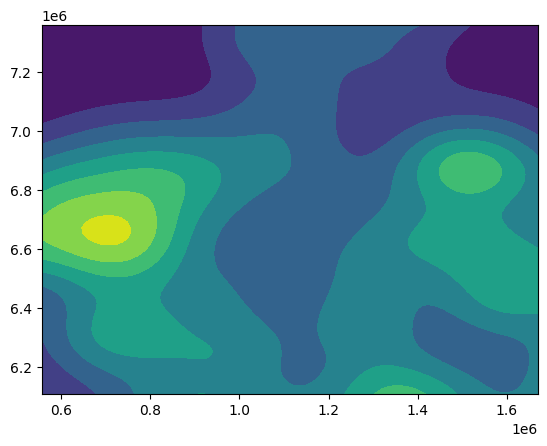

In [ ]:
# preview
#plt.scatter(X[:,1], X[:,0], c=y, norm='log', label="Observations")

p = plt.contourf(X, Y, map)
plt.show()

# 3D using location and time when the spot was recorded (might use single ratings of spots here instead averaged)